In [18]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import application_examples.helpers.plotting_linear as plt
import application_examples.helpers.training as train

In [19]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

# Learning a linear system
This is a simple example to show how to use the `torchdiffeq` library to learn a linear system of ODEs. We'll explore two different models and compare the results. The first model is neural network with a hidden layer and a non-linear activation function (we'll try two of them). The second model is a simpler neural network with no hidden layers and no activation function. Basically, it is a linear model. This is to show that knowing the structure of the system can help us choose a simpler model that works better.

## Model 1: Can we approximate the vector field with a MLP?

In this section we try with two different neural networks, differing only in the activation function. The frist one uses a tanh activation function and the second one uses a ReLU activation function.

### Hyperparameters

In [20]:
args = {
    'method': 'dopri5',
    'data_size': 5000,
    'batch_time': 20,
    'batch_size': 2500,
    'niters': 100000,
    'test_freq': 1000,
    'terminal_time': 25.,
    'learning_rate': 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

The model needs data to train on. Let's create a linear system that will be used as the underlying system to learn. 

In [21]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


#### Define the real system
First define the real system, which is a linear system of ODEs with a known solution. Then calculate the solution of the system using the `odeint` function from `torchdiffeq` and plot the solution.

In [22]:
true_y0 = torch.tensor([[2., 0.]])
true_A = torch.tensor([[-0.1, 3.0], [-3.0, -0.1]])

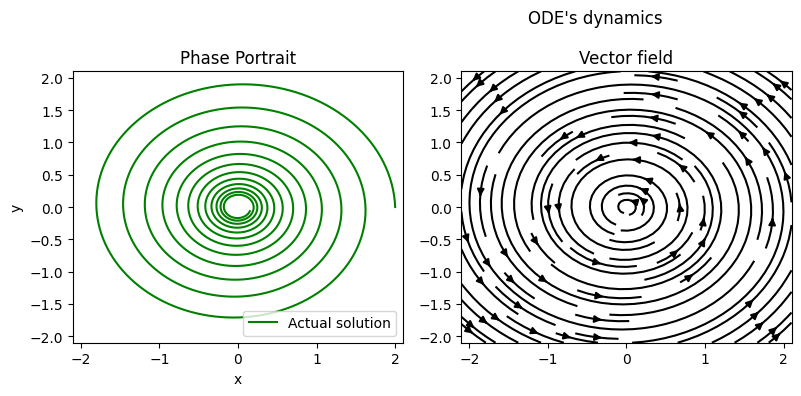

In [23]:
true_vector_field = lambda t, y: torch.mm(y, true_A)
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')
plt.plot_ode(true_y, true_vector_field)

### Testing different activation functions

### Tanh

In [7]:
# Define a Neural Network to learn the vector field
class ODEnnT(nn.Module):

    def __init__(self):
        super(ODEnnT, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnT()

#### Train the neural network

In [8]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.traigitn_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 369.741943
Iter 1000 | Total Loss 85.306786
Iter 2000 | Total Loss 23.825863
Iter 3000 | Total Loss 17.365526
Iter 4000 | Total Loss 12.634933
Iter 5000 | Total Loss 10.152092
Iter 6000 | Total Loss 8.817535
Iter 7000 | Total Loss 7.798129
Iter 8000 | Total Loss 7.180486
Iter 9000 | Total Loss 6.436991
Iter 10000 | Total Loss 6.169669
Iter 11000 | Total Loss 6.285904


KeyboardInterrupt: 

In [ ]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [ ]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

In [ ]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. However, when looking at the graph one can appreciate the solution goes faster than the actual system.

Actually, it seems the model is not able to learn the vector trajectory of the solution with much precision after some time. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [ ]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

In [ ]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

This generalisation has a much higher error than the previous one. This is because the vector field has much larger values in the vicinity of the new initial condition. Not only does this cause the error, in general, to be much larger, but it also makes the system more sensitive to small discrepancies in the predicted points, which add up to a large error. However, when looking at the graph the solution seems to fit rather well. 

### ReLU

In [26]:
# Define a Neural Network to learn the vector field
class ODEnnR(nn.Module):

    def __init__(self):
        super(ODEnnR, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnR()

#### Train the neural network

In [27]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 116.640015
Iter 0001 | Total Loss 114.132629
Iter 0002 | Total Loss 112.014832
Iter 0003 | Total Loss 110.230713
Iter 0004 | Total Loss 109.550644
Iter 0005 | Total Loss 108.491005
Iter 0006 | Total Loss 107.329193


KeyboardInterrupt: 

In [ ]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

Comparing with the `tanh` model, this one has converged much faster and to a lower error. This seems to indicate that the `ReLU` activation function is better suited for this problem. This makes sense considering the vector field is linear. 

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [ ]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

In [ ]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [ ]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method=args['method'])

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

In [ ]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

Again, the model has trained much faster and to a lower error than the `tanh` model.

### Results

Having trained both models, we can compare the results. The `ReLU` model has trained much faster and to a lower error than the `tanh` model. Considering the vector field is linear, this makes sense. The `ReLU` activation function is better suited for this problem.

## Model 2: Can we improve the results by simplifying the model?
This is a very simple system. In fact, the vector field we are trying to learn is linear. Therefore, the neural network doesn't need to be able to learn a non-linear function. Let's try to simplify the model by removing the hidden layer and the activation function.

### New hyperparameters

In [ ]:
args = {
    'method': 'dopri5',
    'data_size' : 5000,
    'batch_time' : 20,
    'batch_size' : 2500,
    'niters' : 25000,
    'test_freq' : 500,
    'terminal_time' : 25.,
    'learning_rate' : 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

In [ ]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


In [ ]:
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')

### The model

In [ ]:
# Define a Neural Network to learn the vector field
class ODELin(nn.Module):

    def __init__(self):
        super(ODELin, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 2 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 4),
            nn.Linear(4, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODELin()

#### Train the neural network

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)    

In [ ]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [ ]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method=args['method'])

In [ ]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

### Try it with a different initial condition

In [ ]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [ ]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

In [ ]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method='dopri5'), t, func, new_losses, args['test_freq'])

### Results
While the error is similar to the `ReLU` model, the training has been much faster, but a lot more unstable. A remarkable difference is that the model already starts with a very low loss when learning a different initial condition. This seems to indicate that when learning the vector field, the linear model has learnt the general structure of the field, while the MLPs have learnt only the area where they were trained.

## Conclusion

### Result comparison
| Model  | Training iterations | Training loss | Generalisation loss | Starting loss new init. cond. | Final loss new init. cond. |
|--------|---------------------|---------------|---------------------|-------------------------------|----------------------------|
| Tanh   | 100000              | 2.738999      | 1.888768            | 466.978180                    | 9.166912                   |
| ReLU   | 46000               | 0.197018      | 0.087709            | 504.146759                    | 0.167796                   |
| Linear | 12500               | 0.143781      | 0.053913            | 0.714123                      | 0.823650                   |

It is evident that the linear model has trained much faster and to a lower error than the MLPs. However, the difference between the ReLU model and the linear model is insignificant for the first two metrics. The real difference is in the generalisation. The linear model has learnt the general structure of the vector field, while the MLPs have learnt only the area where they were trained. This is clear when looking at the starting loss when learning a different initial condition. The linear model has a very low loss, while the MLPs have a very high loss. This indicates that if we wish for a model that learns the dynamics of the system regardless of where it's trained, the linear model is the best choice. However, when training specifically for a certain area, the MLPs are better suited for the task, as it can be seen in the final loss when learning a different initial condition for the `ReLU` model.

Furthermore, simple neural networks have the capacity to approximate any function, which makes them the best candidates when trying to learn the voctor field of a system, even if we know its structure. This comes at the cost of longer training times, and more data. The data constraint is not a problem in this case, as we can generate as much data as we need.